1. Introduction

This project was developed as the Capstone Project for the UC Berkeley Professional Certificate in Machine Learning and Artificial Intelligence Program. This project explores how ThousandEyes synthetic monitoring data—specifically `ping` and `http` metrics—can help detect early signs of outages or network degradation. The goal is to extract meaningful patterns and correlations from high-resolution time series data.

This notebook focuses first on `ping` metrics: packet loss and latency, measured across various virtual agents and test rounds.


2. Background:
In today’s digitally connected world, ensuring consistent network and application performance is vital for business operations and user satisfaction. Companies depend on performance monitoring systems to detect issues that may affect availability, latency, or user experience. However, current monitoring practices are often reactive—detecting issues only after user impact is noticeable. With the increasing complexity of distributed systems, identifying early signs of outages or systemic degradation is becoming increasingly difficult using traditional monitoring methods.

Current monitoring strategies at companies like ThousandEyes rely on collecting a wide range of network and application metrics such as packet loss, latency, and HTTP response time. However, these signals are often examined in isolation, without a structured approach to correlate them or derive predictive insights. As a result, outages are often detected reactively rather than proactively.

This project focuses on analyzing anonymized, high-resolution internal test data for Ping and HTTP metrics related to Spotify, a major digital platform that experienced a recent outage. The data comes from ThousandEyes synthetic tests, which simulate user behavior to monitor network and application health in real time. A recent Spotify outage highlighted the challenge of quickly diagnosing whether an issue is network-related, application-based, or global. By studying internal ThousandEyes data corresponding to such incidents, we aim to investigate if machine learning or statistical techniques can uncover predictive indicators of impending failures.

Capstone Research Question
Can internal ThousandEyes synthetic test data (e.g., packet loss, latency, HTTP response time) be used to detect early warning signals, identify anomalies, and improve the detection of outages through correlation and predictive modeling?

3. Data Loading and Preprocessing
Goal: Load the raw ThousandEyes test data (Ping and HTTP), inspect its structure, parse timestamps, and clean it for analysis.

1. Import the relevant python libraries for the analysis

In [80]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

2. Load the Ping dataset

In [82]:
#Load and Preview Ping Data
ping_df = pd.read_csv('ping_spotify_3.csv')

3. Basic Data Understanding. Visually inspect the head of the Ping dataset,Examine the Ping dataset to understand in particular if the data is tidy, shape of the dataset,examine datatypes, examine missing values, unique counts and build a data dictionary dataframe

Conditions to check if **data is tidy**

Is every column a variable?
Is every row an observation?
Is every table a single observational unit?

In [84]:
# Summary statistics
ping_df.describe()

,roundId,vAgentId,testId,loss,latency
count,1.728090e+05,172809.000000,1.728090e+05,171360.000000,171044.000000
mean,1.744545e+09,40114.777679,3.212237e+06,0.383012,33.226454
std,1.247110e+05,113368.594999,9.366758e+00,5.375218,60.346188
min,1.744330e+09,3.000000,3.212221e+06,0.000000,0.000000
25%,1.744438e+09,34.000000,3.212229e+06,0.000000,0.967742
50%,1.744546e+09,273.000000,3.212239e+06,0.000000,4.771780
75%,1.744654e+09,27665.000000,3.212244e+06,0.000000,33.304342
max,1.744761e+09,639001.000000,3.212247e+06,100.000000,362.674957


In [85]:
#inspect the first few rows of the Ping dataset
ping_df.head(10)

,roundId,vAgentId,testId,loss,latency
0,1744706700,639001,3212239,NaN,NaN
1,1744706700,56265,3212239,0.0,149.000000
2,1744706700,42311,3212239,0.0,20.416666
3,1744706700,32,3212239,0.0,25.021738
4,1744706700,73,3212239,0.0,20.021740
5,1744706700,66222,3212239,0.0,212.065247
6,1744706700,68,3212239,0.0,91.065224
7,1744706700,27665,3212239,0.0,241.045486
8,1744706700,3,3212239,0.0,174.687469
9,1744706700,39779,3212239,0.0,210.065231


The columns with missing data in ping dataset are:loss and latency
This is evident from the first row, where both loss and latency have NaN values. The other columns (roundId, vAgentId, and testId) have no missing values.

In [87]:
# Dataset shape
print("Rows:", ping_df.shape[0], "Columns:", ping_df.shape[1])

Rows: 172809 Columns: 5


By calling the shape attribute of the Ping dataset we can observe that there are 172809 observations and 5 columns
in the data set

In [89]:
# Data types and nulls
ping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172809 entries, 0 to 172808
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   roundId   172809 non-null  int64  
 1   vAgentId  172809 non-null  int64  
 2   testId    172809 non-null  int64  
 3   loss      171360 non-null  float64
 4   latency   171044 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 6.6 MB


Observations: roundId, vAgentId, and testId have no missing values.
loss has 1,449 missing values (172,809 - 171,360).
latency has 1,765 missing values (172,809 - 171,044).
The data types indicate: int64: whole numbers, float64: decimal numbers, typical for measurements like loss and latency. This shows that we have a numeric dataset (no strings or dates). Hence, a clean and analysis-ready dataset.

In [97]:
# Information on the columns
ping_df.info

<bound method DataFrame.info of            roundId  vAgentId   testId  loss     latency
0       1744706700    639001  3212239   NaN         NaN
1       1744706700     56265  3212239   0.0  149.000000
2       1744706700     42311  3212239   0.0   20.416666
3       1744706700        32  3212239   0.0   25.021738
4       1744706700        73  3212239   0.0   20.021740
...            ...       ...      ...   ...         ...
172804  1744371600      7815  3212247   0.0    0.480000
172805  1744371600      7815  3212229   0.0    0.000000
172806  1744371600      7815  3212244   0.0    0.461538
172807  1744371600      7815  3212239   0.0  195.024384
172808  1744371600      7815  3212221   0.0    0.200000

[172809 rows x 5 columns]>

In [103]:
ping_df.nunique()

roundId      1440
vAgentId       38
testId          5
loss           69
latency     34880
dtype: int64

In [18]:
ping_df[['loss', 'latency', 'vAgentId']].corr()

,loss,latency,vAgentId
loss,1.000000,0.050102,-0.007327
latency,0.050102,1.000000,-0.021923
vAgentId,-0.007327,-0.021923,1.000000


There seems to have a positive coorelation between latency and loss over 5%, and a insignificant negative co-relation between vagentiD and other columns. 

Latency and Loss Distribution

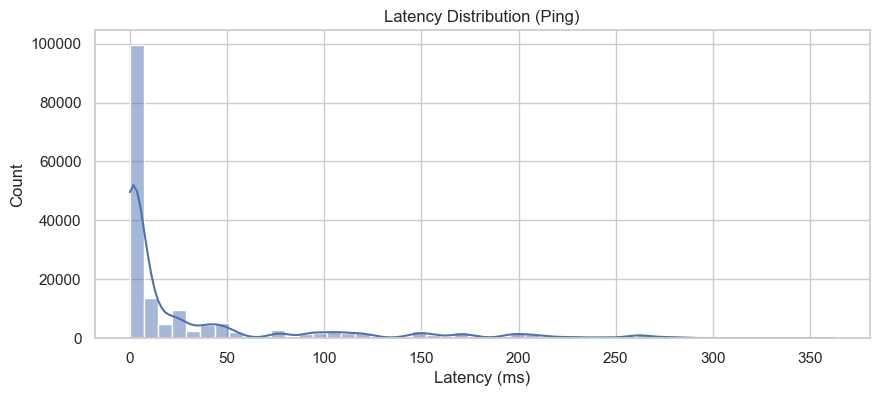

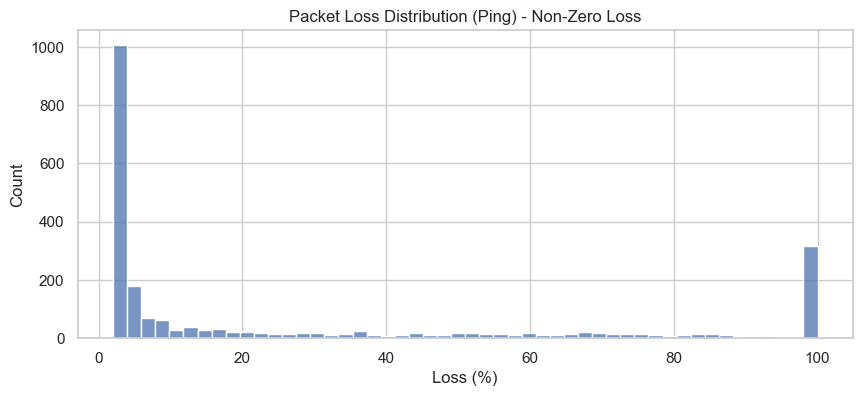

In [21]:
# Latency
plt.figure(figsize=(10, 4))
sns.histplot(ping_df['latency'], bins=50, kde=True)
plt.title("Latency Distribution (Ping)")
plt.xlabel("Latency (ms)")

# Loss
loss_data = ping_df['loss']
non_zero_loss_data = loss_data[loss_data > 0]
if not non_zero_loss_data.empty:
    plt.figure(figsize=(10, 4))
    sns.histplot(non_zero_loss_data, bins=50, kde=False) # Or adjust bins as needed
    plt.title("Packet Loss Distribution (Ping) - Non-Zero Loss")
    plt.xlabel("Loss (%)") # Assuming loss is a percentage
    plt.ylabel("Count")
    plt.show()
else:
    print("No non-zero packet loss events to plot.")

Majority of packet loss is near 0, and latency is mostly 0 to 0-50. However there seems to be outliers around 250. 

There is a blip in packet loss around a 100% and this could be due to an extended outage. Let's look at outliers for latency 

Spot Outliers for Entire Data sets

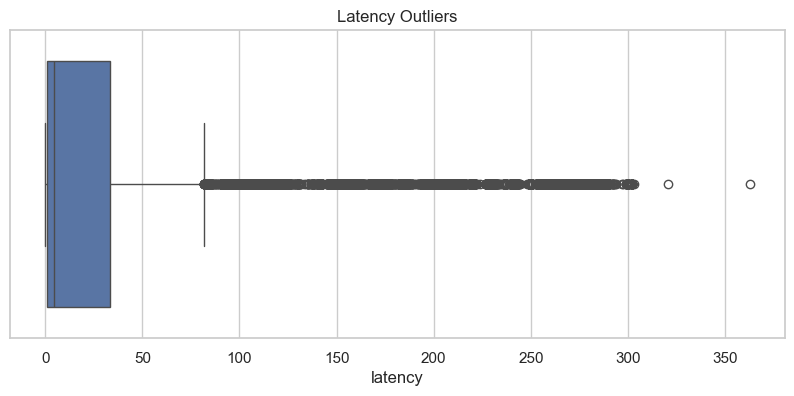

In [25]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=ping_df['latency'])
plt.title('Latency Outliers')
plt.show()

Spot Outliers for AgentIDs

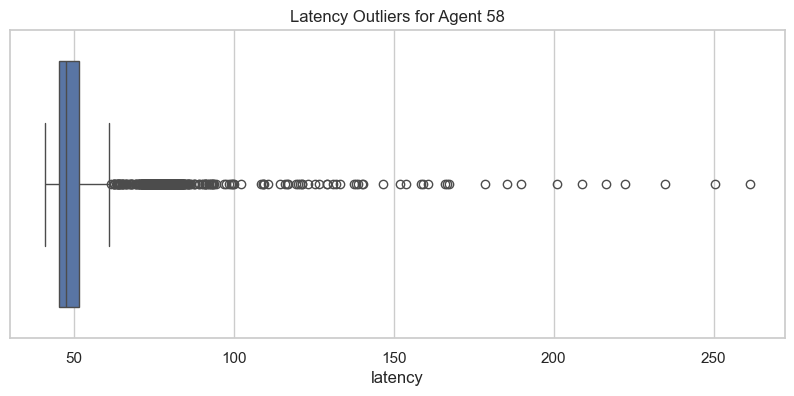

In [27]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=ping_df[ping_df['vAgentId'] == 58]['latency'])
plt.title('Latency Outliers for Agent 58')
plt.show()

Spot Outliers for TestID's

Grouped Metrics for Exploration

In [ ]:
# Mean latency per agent
ping_df.groupby("vAgentId")['latency'].mean().sort_values(ascending=False).head()

# Loss > 0 occurrences
ping_df[ping_df['loss'] > 0].groupby("vAgentId")['loss'].count().sort_values(ascending=False).head()

Let’s check for:
Duplicate rows
Zero or near-zero variance
Latency outliers

In [ ]:
# Check duplicates
duplicates = ping_df.duplicated().sum()
print("Duplicate rows:", duplicates)

# Remove duplicates if needed
ping_df.drop_duplicates(inplace=True)

# Remove outliers above 99th percentile for latency
latency_threshold = ping_df['latency'].quantile(0.99)
ping_df_clean = ping_df[ping_df['latency'] <= latency_threshold]

print("Rows after removing high latency outliers:", ping_df_clean.shape[0])

Explore Relationships: Correlation Matrix

In [ ]:
#Correlation matrix between numeric columns (loss, latency) and others.
plt.figure(figsize=(6, 4))
sns.heatmap(ping_df[['loss', 'latency']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Ping Metrics)")

Because roundId looks like a Unix timestamp in seconds, converting it will give you actual timestamps for time series analysis.

In [ ]:
# Convert roundId to datetime
ping_df['timestamp'] = pd.to_datetime(ping_df['roundId'], unit='s')

# Check result
ping_df[['roundId', 'timestamp']].head()

In [ ]:
# Rearrange columns for readability
ping_df = ping_df[['timestamp', 'roundId', 'vAgentId', 'testId', 'loss', 'latency']]

In [ ]:
normalize (remove outliers)

In [ ]:
pattern (facts) by dimensions 

In [ ]:
what is loss/latency  by round id 

Time Series Overview

In [ ]:
What is loss by vagent id / testId

In [ ]:
#Plot how loss and latency change over time (using the timestamp).
plt.figure(figsize=(14,6))
plt.plot(ping_df['timestamp'], ping_df['latency'], marker='.', linestyle='None', alpha=0.3)
plt.title('Latency over Time')
plt.xlabel('Timestamp')
plt.ylabel('Latency (ms)')
plt.show()

Aggregate by minute/hour to reduce noise:

In [ ]:
ping_df.set_index('timestamp', inplace=True)
latency_hourly = ping_df['latency'].resample('H').mean()

latency_hourly.plot(figsize=(14,6))
plt.title('Average Latency per Hour')
plt.ylabel('Latency (ms)')
plt.show()

Time Series Overview

In [ ]:
#Line plot for latency over time:
plt.figure(figsize=(12, 4))
plt.plot(ping_df['timestamp'], ping_df['latency'], color='blue')
plt.title('Latency Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Latency (ms)')
plt.tight_layout()
plt.show()


Grouping and Aggregation

In [ ]:
#Group by vAgentId or testId to find patterns or problematic agents/tests.
ping_df.groupby('vAgentId')['latency'].mean().sort_values(ascending=False).head(10)
ping_df.groupby('testId')['loss'].mean().sort_values(ascending=False).head(10)

In [ ]:
#Line plot for loss:
plt.figure(figsize=(12, 3))
plt.plot(ping_df['timestamp'], ping_df['loss'], color='red')
plt.title('Loss Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Loss (%)')
plt.tight_layout()
plt.show()

Anomaly Detection

In [ ]:
# Introduce simple anomaly detection techniques (e.g., threshold-based or rolling statistics) on latency or loss to flag potential outages.
ping_df['latency_rolling_mean'] = ping_df['latency'].rolling(window=60).mean()
ping_df['latency_rolling_std'] = ping_df['latency'].rolling(window=60).std()

# Define anomaly if latency is > rolling mean + 3*std
ping_df['latency_anomaly'] = ping_df['latency'] > (ping_df['latency_rolling_mean'] + 3 * ping_df['latency_rolling_std'])

# Visualize anomalies
plt.figure(figsize=(14,6))
plt.plot(ping_df.index, ping_df['latency'], label='Latency')
plt.scatter(ping_df.index[ping_df['latency_anomaly']], ping_df['latency'][ping_df['latency_anomaly']], color='red', label='Anomaly')
plt.legend()
plt.show()

 Segmented Analysis

In [ ]:
#by agent
agent_latency = ping_df.groupby('vAgentId')['latency'].mean().sort_values(ascending=False)
agent_latency.head(10).plot(kind='bar', figsize=(10, 4), title='Top 10 Agents by Avg Latency')
plt.ylabel('Latency')
plt.show()

In [ ]:
#Let's do Similar analysis By Test ID
testId_latency = ping_df.groupby('testId')['latency'].mean().sort_values(ascending=False)
testId_latency.head(10).plot(kind='bar', figsize=(10, 4), title='Top 10 Test ID by Avg Latency')
plt.ylabel('Latency')
plt.show()

Now Lets's Combine Ping Multiple CSV's into one Ping file, Data for 5 Spotify tests (April 1st - 25th). Outage happened on April 16th. There are five files for each PING. Each file has five days of data: first file has data for 1st-5th, second file has data for 6th-10 and so on. 